## Problem 2: Controlling a Rocket Landing: Reachability Analysis

In [65]:
'''
Install required dependencies
'''
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope

In [66]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt

'''
Helper Functions
'''
def minkowski_sum(X, Y):
    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
    if not B.any():
        return pt.Polytope(Xset.A @ A, Xset.b)
        
    tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
    return pt.Polytope(tmp.A @ A, tmp.b)
    
def Oinf(Xset, A, Wset=pt.Polytope()):
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap

In [67]:
'''
Do not modify this cell!
'''
from scipy.signal import place_poles

# Parameters
m = 27648
l = 70
J = (1/16)*m*l**2
g = 9.8
TS = 0.1
F_nom = m*g

# Constraints
x_u = np.array([20*np.pi/180, 100])
x_l = np.array([-20*np.pi/180, -100])
u_u = 5*np.pi/180
u_l = -5*np.pi/180

# Model matrices
A = np.array([[1, TS], [0, 1]])
B = np.array([[0], [-TS*(l/(2*J))*F_nom]])

# Constraint matrices
H_x = np.vstack((np.eye(2), -np.eye(2)))
h_x = np.concatenate((x_u, -x_l)).reshape((-1,1))
H_u = np.array([1, -1]).reshape((-1,1))
h_u = np.array([u_u, -u_l]).reshape((-1,1))

### Part a)

Single polytope 
  [[ 0.99877 -0.04963] |    [[0.0195 ]
   [-0.99877  0.04963] |     [0.0195 ]
   [-0.3816  -0.92433] x <=  [0.03315]
   [ 0.3816   0.92433] |     [0.03315]
   [-0.92125 -0.38897] |     [0.004  ]
   [ 0.92125  0.38897]]|     [0.004  ]]



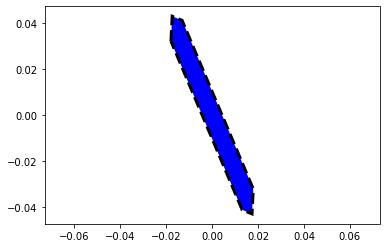

In [68]:
'''
Your code here
'''
p = [0.5, 0.55]
K = place_poles(A,B,p).gain_matrix

X = pt.Polytope(np.array([[1.0, 0], 
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]), 
                np.array([[x_u], 
                          [x_u],
                          [x_u],
                          [x_u]]))

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([u_u, u_u]).reshape(2,1))


# target set

A_cl = A - B@K
S = X.intersect(pt.Polytope(U.A@K, U.b))
O_inf1 = Oinf(S, A_cl)
print(O_inf1) #List of H-representation equations

fig, ax = plt.subplots()
O_inf1.plot(ax, color='b')
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part b)

Single polytope 
  [[ 0.93189 -0.36274] |    [[0.06396]
   [-0.93189  0.36274] |     [0.06396]
   [-0.11915 -0.99288] |     [0.06337]
   [ 0.11915  0.99288] x <=  [0.06337]
   [-0.74154 -0.67091] |     [0.01972]
   [ 0.74154  0.67091] |     [0.01972]
   [-0.85027 -0.52635] |     [0.00791]
   [ 0.85027  0.52635]]|     [0.00791]]



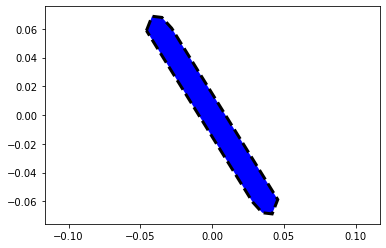

In [69]:
'''
Your code here
'''
p = [0.7, 0.65]
K = place_poles(A,B,p).gain_matrix

# target set

A_cl = A - B@K
S = X.intersect(pt.Polytope(U.A@K, U.b))
O_inf2 = Oinf(S, A_cl)
print(O_inf2) #List of H-representation equations

fig, ax = plt.subplots()
O_inf2.plot(ax, color='b')
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part c)

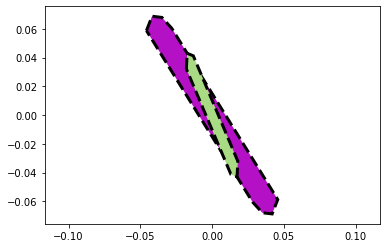

In [70]:
'''
Your code here
'''
fig, ax = plt.subplots()
O_inf2.plot(ax)
O_inf1.plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part d)

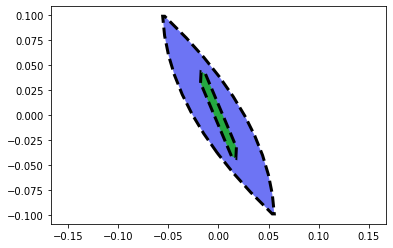

In [71]:
'''
Your code here
'''
N = 10
# target set

C = {}
# Since the Polytope package cannot handle non full-dimensional
# polytopes, we need to define an epsilon box around zero in
# order to run the code:
eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])

fig, ax = plt.subplots()
PreS = precursor(S, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0 = C[N-1]
X0.plot(ax)
O_inf1.plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part e)

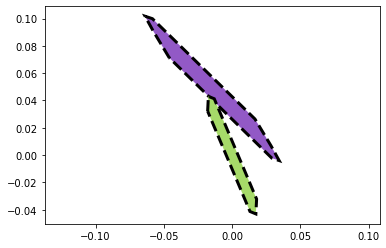

In [97]:
def precursor_const_u(Xset, A, u, B=np.array([])):
    if not B.any():
        return pt.Polytope(Xset.A @ A, Xset.b)
        
    tmp  = minkowski_sum( Xset, -(B*u).reshape((1,-1)) )
    return pt.Polytope(tmp.A @ A, tmp.b)

'''
Your code here
'''

P = 6

C = {}
S = X.intersect(pt.Polytope(U.A@K, U.b))
u = 5*np.pi/180

fig, ax = plt.subplots()
PreS = precursor(O_inf1, A, U, B)
for j in range(P):
    C[j]= PreS.intersect(X)
    PreS = precursor_const_u(C[j], A, u, B)

R1 = C[P-1]
R1.plot(ax)
O_inf1.plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

### Part f)

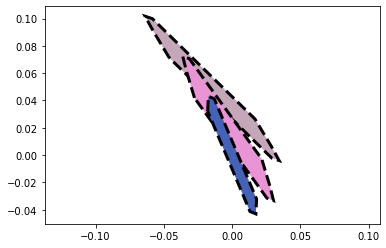

In [99]:
'''
Your code here
'''
P = 3

C = {}
S = X.intersect(pt.Polytope(U.A@K, U.b))
u = 5*np.pi/180

fig, ax = plt.subplots()
PreS = precursor(O_inf1, A, U, B)
for j in range(P):
    C[j]= PreS.intersect(X)
    PreS = precursor_const_u(C[j], A, u, B)

R2 = C[P-1]
R1.plot(ax)
R2.plot(ax)
O_inf1.plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()